# GOLDEN CROSS STRATEGY:

In [1]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os
import warnings

In [2]:
# Store the data as a panda dataframe
btc = pd.read_csv('BTC-USD.csv')
btc['Date'] = pd.to_datetime(btc['Date']) 
btc = btc.set_index('Date')
btc['log_ret'] = np.log(btc['Adj Close']).diff()
btc['variance'] = btc['log_ret'].rolling(180).var()
btc = btc['2018':'2022-01-31']

max_adj_close = btc['Adj Close'].max()
min_adj_close = btc['Adj Close'].min()

print(btc) # Truncated the data until 30th Dec 2011 for better visibility
print("Max Adj. Close Price = ", max_adj_close)
print("Min Adj. Close Price = ", min_adj_close)

                    Open          High           Low         Close  \
Date                                                                 
2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
2018-01-05  15477.200195  17705.199219  15202.799805  17429.500000   
...                  ...           ...           ...           ...   
2022-01-27  36841.878906  37148.324219  35629.281250  37138.234375   
2022-01-28  37128.445313  37952.878906  36211.109375  37784.332031   
2022-01-29  37780.714844  38576.261719  37406.472656  38138.179688   
2022-01-30  38151.917969  38266.339844  37437.710938  37917.601563   
2022-01-31  37920.281250  38647.261719  36733.574219  38483.125000   

               Adj Close       Volume   log_ret  variance  
Date                         

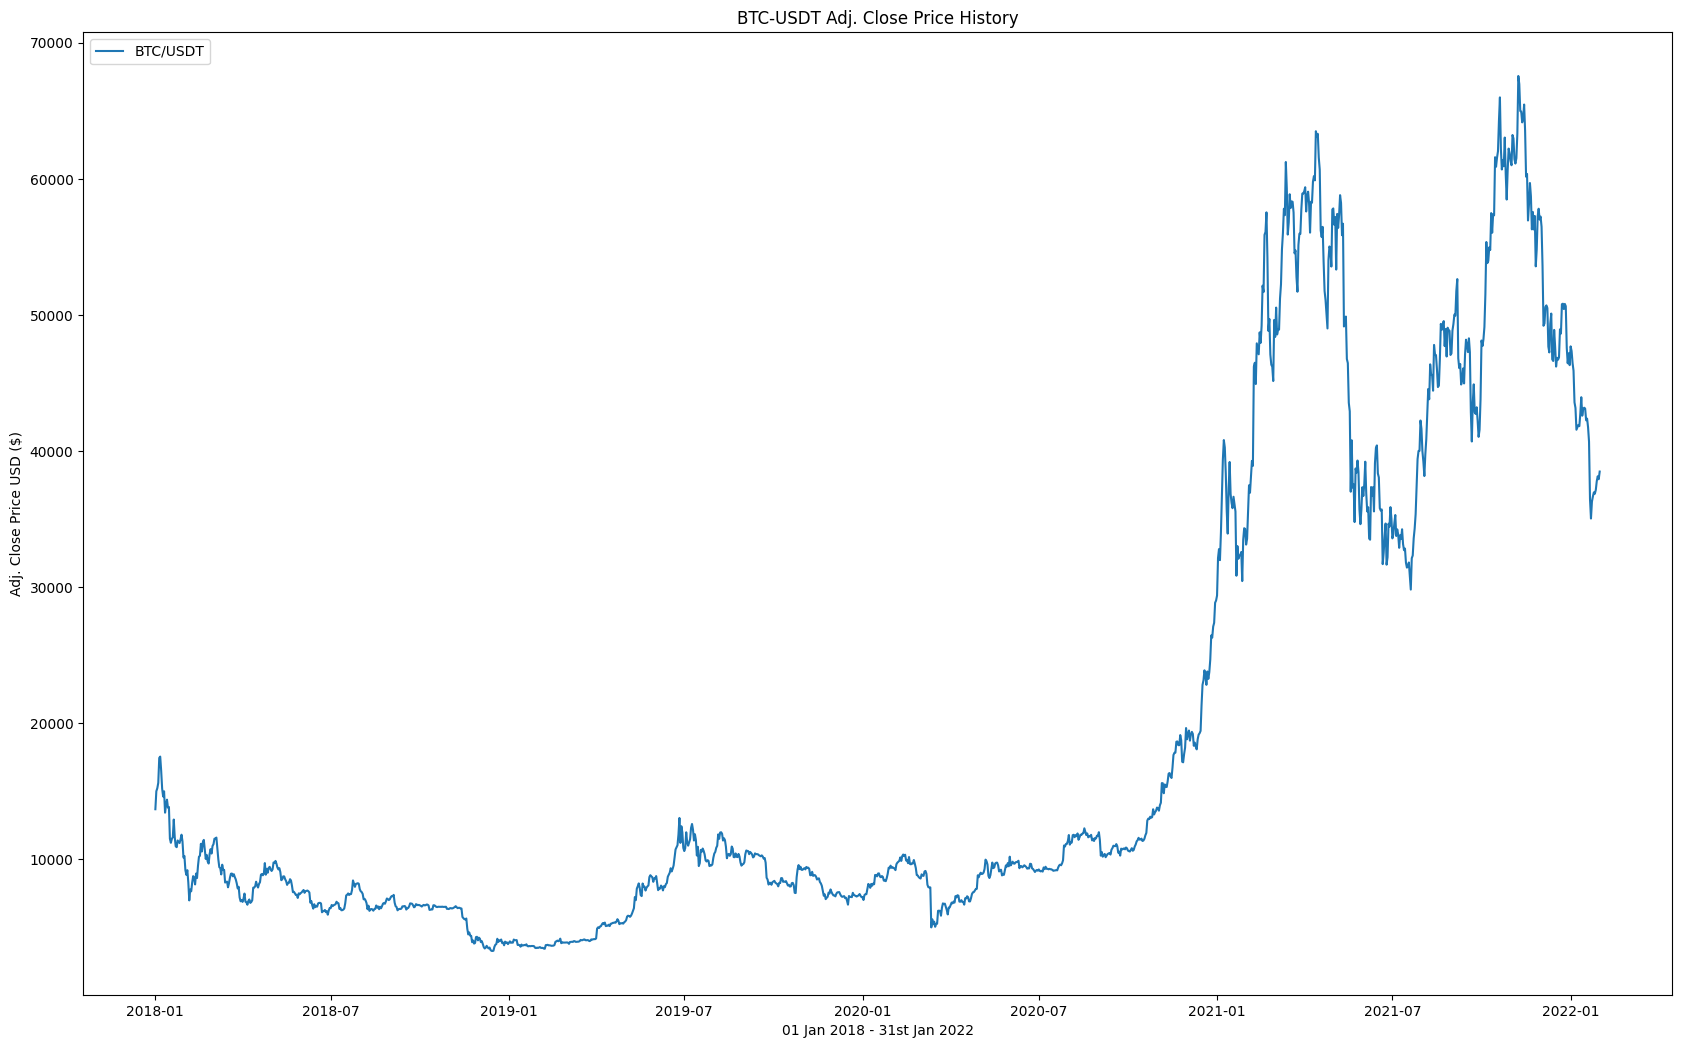

In [3]:
plt.figure(figsize=(20.5,12.5)) # sizes are in inches
plt.plot(btc['Adj Close'], label = 'BTC/USDT') # adjusted price on the x axis
plt.title('BTC-USDT Adj. Close Price History')
plt.xlabel('01 Jan 2018 - 31st Jan 2022')
plt.ylabel('Adj. Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

In [4]:
# Setup Moving Average Windows
Window_lower = 12 # short-term
Window_upper = 45 # long-term

# Short term moving average
SMA_short = pd.DataFrame() # simple moving average
SMA_short['Adj Close']= btc['Adj Close'].rolling(window = Window_lower).mean()

# Long term moving average
SMA_long = pd.DataFrame() # simple moving average
SMA_long['Adj Close']= btc['Adj Close'].rolling(window = Window_upper).mean()


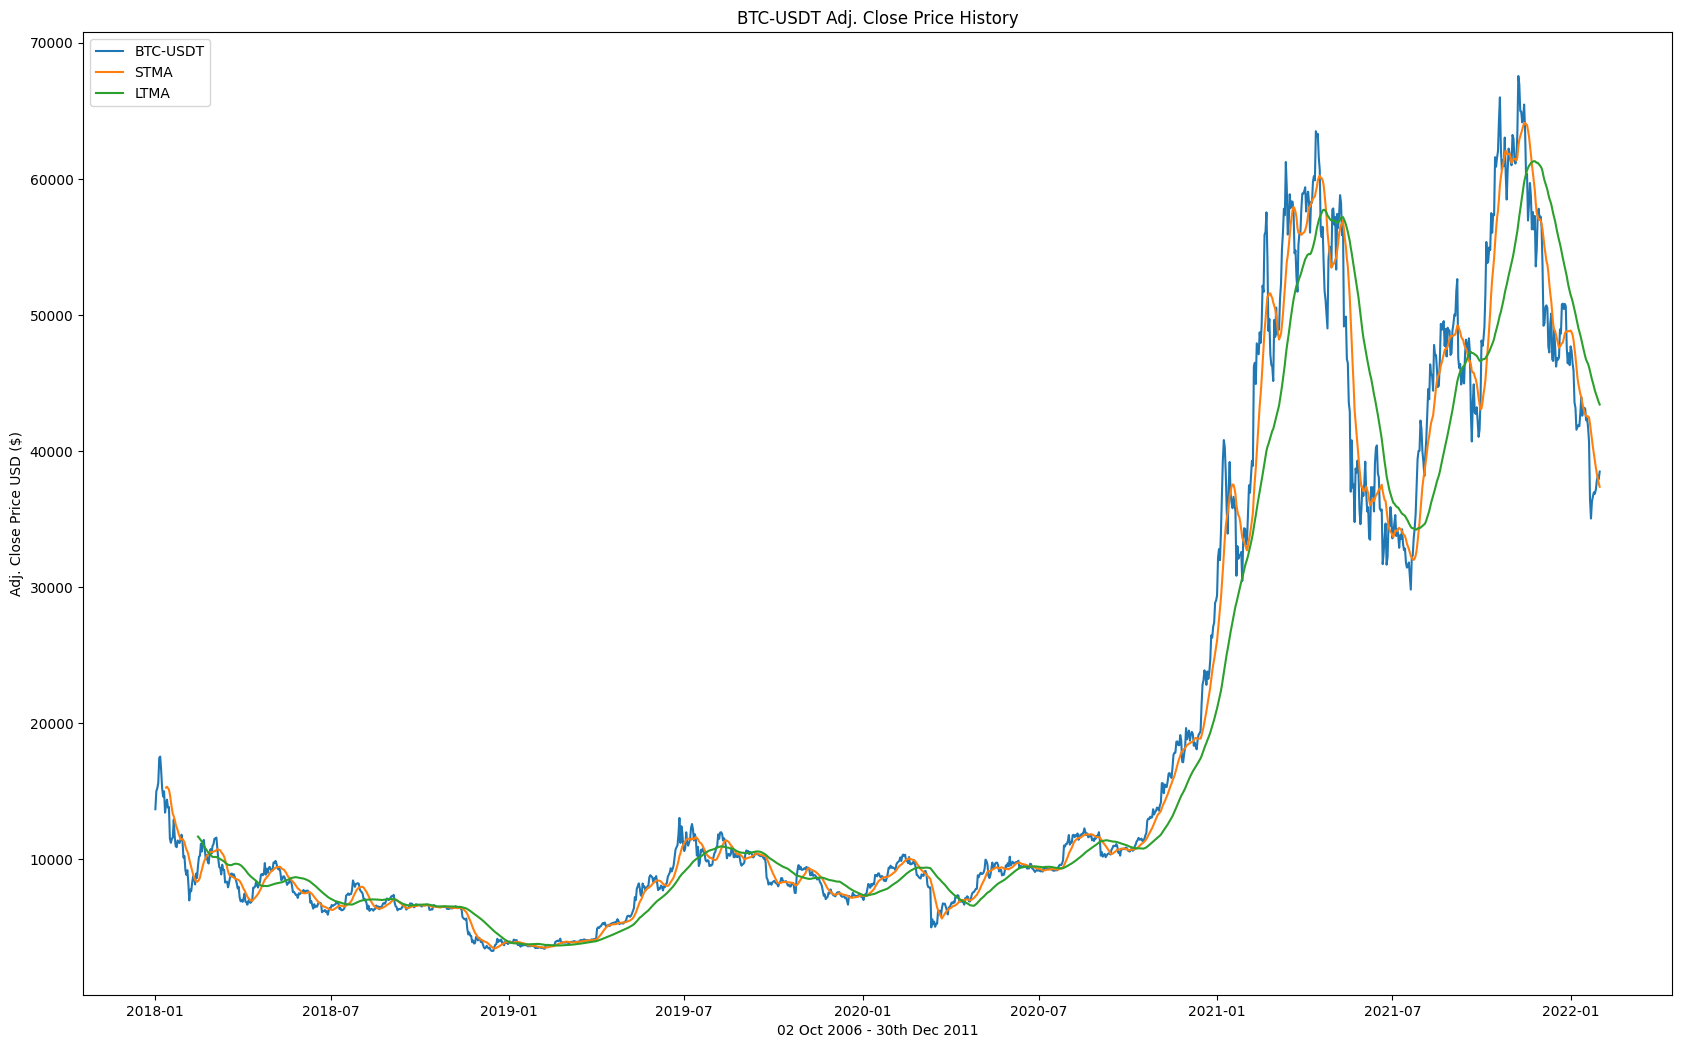

In [5]:
# Plot the short and long term moving averages with the raw data
plt.figure(figsize=(20.5,12.5)) # sizes are in inches
plt.plot(btc['Adj Close'], label = 'BTC-USDT') # adjusted price on the x axis
plt.plot(SMA_short['Adj Close'], label = 'STMA') # short term moving avg
plt.plot(SMA_long['Adj Close'], label = 'LTMA') # long term moving avg
plt.title('BTC-USDT Adj. Close Price History')
plt.xlabel('02 Oct 2006 - 30th Dec 2011')
plt.ylabel('Adj. Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

In [6]:
btc['ATR'] = ATR = pd.concat([btc.High.sub(btc.Low), btc.High.sub(btc.Close.shift()).abs(), btc.Low.sub(btc.Close.shift()).abs()], axis=1).max(1).ewm(span=14).mean()
btc


,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,ATR
Date,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,-0.035900,0.003341,957.500000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,0.092589,0.003380,1666.517857
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,0.014505,0.003369,1308.115375
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,0.025858,0.003369,1280.393576
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,0.110945,0.003420,1599.213029
...,...,...,...,...,...,...,...,...,...
2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,37138.234375,25041426629,0.007734,0.001148,2180.488645
2022-01-28,37128.445313,37952.878906,36211.109375,37784.332031,37784.332031,22238830523,0.017248,0.001140,2121.992763
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,38138.179688,17194183075,0.009321,0.001139,1995.032270


In [7]:
# Create dataset to store short and long term moving avg
moving_avg = pd.DataFrame()
moving_avg['BTC']= btc['Adj Close']
moving_avg['STMA']= SMA_short['Adj Close']
moving_avg['LTMA']= SMA_long['Adj Close']
moving_avg['ATR']=btc['ATR']

In [8]:
# Create Buy vs Sell signals

def investment_signal(data):
    
    sigPriceToBuy = []
    sigPriceToSell = []
    isCross = -1 # flag to check when STMA crosses over LTMA
    for i in range(len(data)):
        
        if data['STMA'][i]> data['LTMA'][i]:
            
            if isCross !=1:
                
                sigPriceToBuy.append(data['BTC'][i]) # good time to buy
                sigPriceToSell.append(np.nan)
                isCross = 1
            else:
                sigPriceToBuy.append(np.nan)
                sigPriceToSell.append(np.nan)
        elif data['STMA'][i]< data['LTMA'][i]:
            if isCross!= 0:
                sigPriceToBuy.append(np.nan) 
                sigPriceToSell.append(data['BTC'][i]) # good time to sell
                isCross = 0
            else:
                sigPriceToBuy.append(np.nan)
                sigPriceToSell.append(np.nan)
        else:
            sigPriceToBuy.append(np.nan)
            sigPriceToSell.append(np.nan)

    return (sigPriceToBuy,sigPriceToSell)

In [9]:
# Store the Buy and Sell data
buy_sell = investment_signal(moving_avg)
moving_avg['Buy_Signal_Price'] = buy_sell[0]
moving_avg['Sell_Signal_Price'] = buy_sell[1]
moving_avg

,BTC,STMA,LTMA,ATR,Buy_Signal_Price,Sell_Signal_Price
Date,,,,,,
2018-01-01,13657.200195,NaN,NaN,957.500000,NaN,NaN
2018-01-02,14982.099609,NaN,NaN,1666.517857,NaN,NaN
2018-01-03,15201.000000,NaN,NaN,1308.115375,NaN,NaN
2018-01-04,15599.200195,NaN,NaN,1280.393576,NaN,NaN
2018-01-05,17429.500000,NaN,NaN,1599.213029,NaN,NaN
...,...,...,...,...,...,...
2022-01-27,37138.234375,38793.988932,44235.703125,2180.488645,NaN,NaN
2022-01-28,37784.332031,38349.860026,44039.518663,2121.992763,NaN,NaN
2022-01-29,38138.179688,38007.162435,43800.439931,1995.032270,NaN,NaN


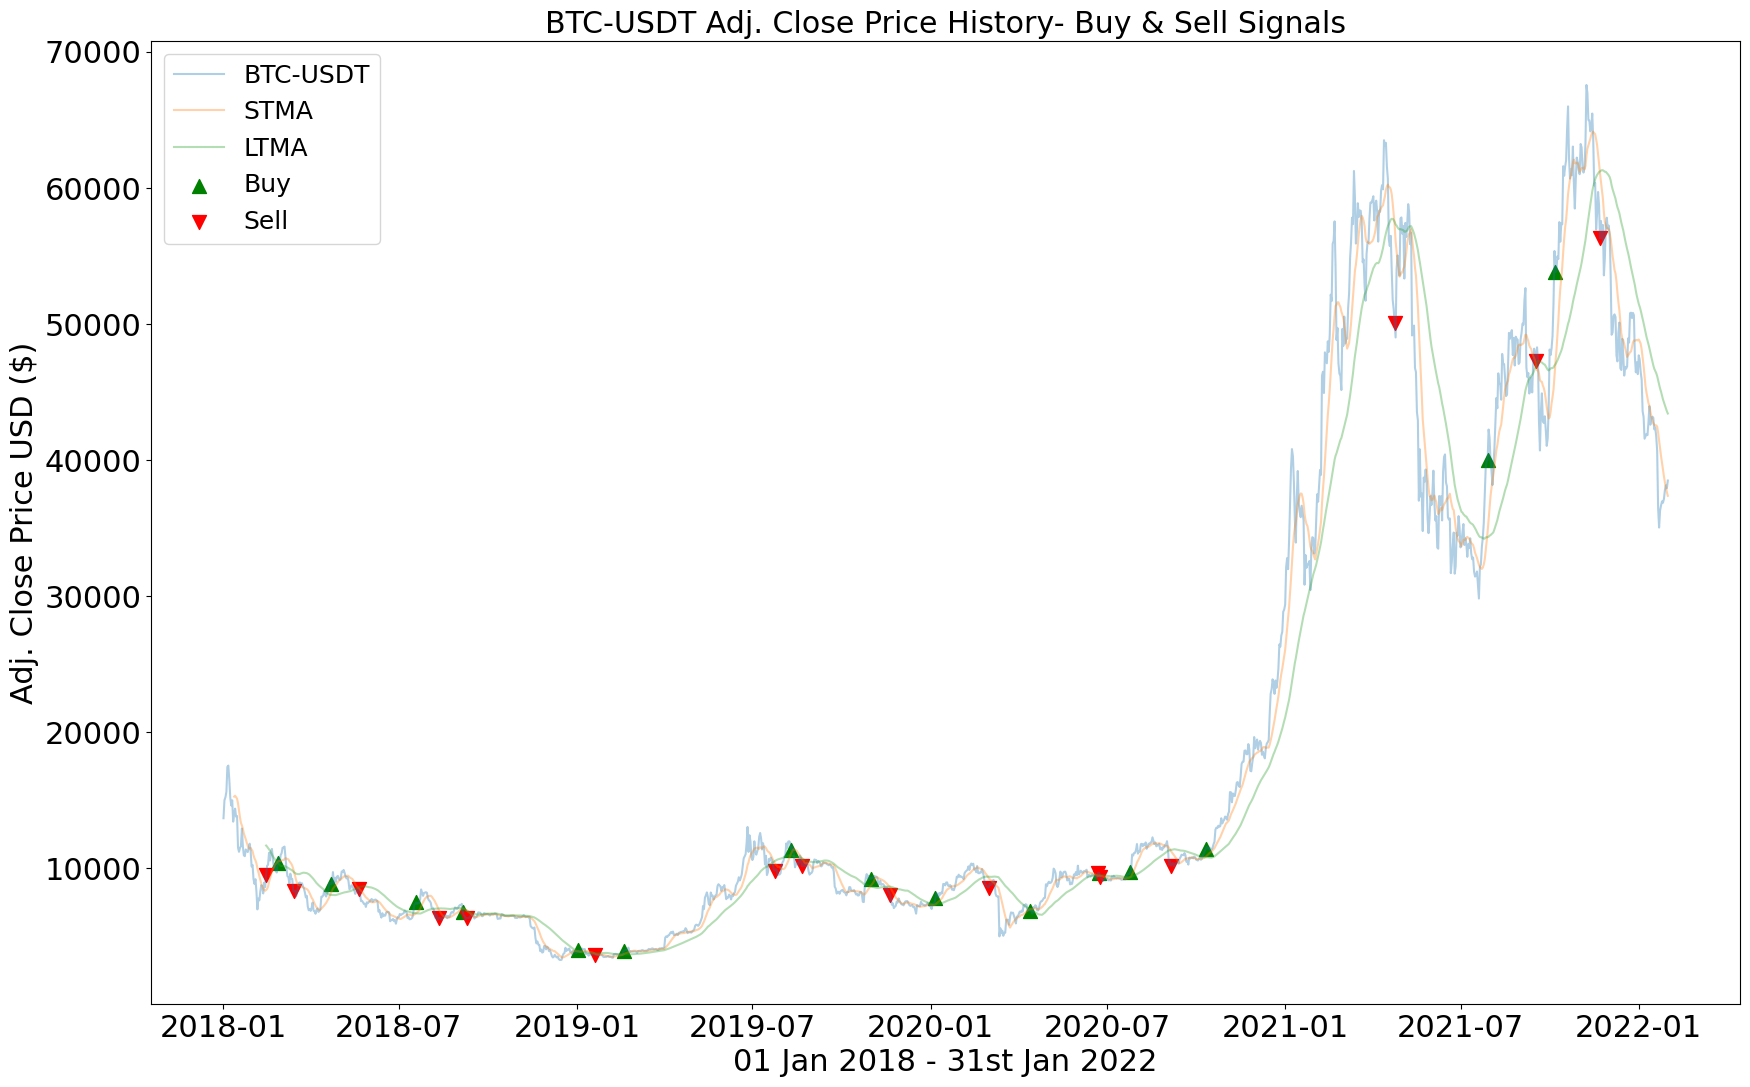

In [14]:
# Plot the data with buy and signal markers
plt.figure(figsize=(20.5,12.5)) # sizes are in inches
plt.plot(btc['Adj Close'], label = 'BTC-USDT',alpha= 0.35) # adjusted price on the x axis
plt.plot(SMA_short['Adj Close'], label = 'STMA',alpha= 0.35) # short term moving avg
plt.plot(SMA_long['Adj Close'], label = 'LTMA',alpha= 0.35) # long term moving avg

plt.rcParams.update({'font.size': 18})

# Buy Signal
plt.scatter(moving_avg.index, moving_avg['Buy_Signal_Price'], label = 'Buy', marker = "^", color="green",s=100) # Decision Made to buy

# Sell Signal
plt.scatter(moving_avg.index,moving_avg['Sell_Signal_Price'], label = 'Sell',  marker = "v", color="red",s=100) # long term moving avg


plt.title('BTC-USDT Adj. Close Price History- Buy & Sell Signals')
plt.xlabel('01 Jan 2018 - 31st Jan 2022')
plt.ylabel('Adj. Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

In [11]:

# Calculate Profit and Losses
def PnL(data):
    loss = 0
    profit = 0
    print(data)
    spent=0
    gained=0
    for i in range(len(data)):
        if str(data['Buy_Signal_Price'][i])!=str(np.NAN):
            spent+=data['Buy_Signal_Price'][i]
        if str(data['Sell_Signal_Price'][i])!=str(np.NAN):
            gained+=data['Sell_Signal_Price'][i]
#     for i in range(0,len(data)-1,2):
#         if (data['Buy_Signal_Price'][i+1] - data['Sell_Signal_Price'][i] >=0):
#             print("1")
#             # we made a loss
#             loss = loss + data['Buy_Signal_Price'][i+1] - data['Sell_Signal_Price'][i]
#         else:
#             print("2")
#             # we made profit
#             profit = profit + data['Buy_Signal_Price'][i+1] - data['Sell_Signal_Price'][i]

    return (profit, loss,spent,gained)

In [12]:
PnL(moving_avg.dropna(subset=['Buy_Signal_Price', 'Sell_Signal_Price'],how='all'))

                     BTC          STMA          LTMA          ATR  \
Date                                                                
2018-02-14   9494.629883   8379.703369  11649.111806   972.007112   
2018-02-26  10366.700195  10461.233480  10372.134093   876.059745   
2018-03-15   8300.860352   9664.933268   9667.771810   825.816211   
2018-04-22   8802.459961   8169.269979   8016.908854   378.305321   
2018-05-21   8418.990234   8486.247518   8586.724653   341.919905   
2018-07-19   7466.859863   6686.944987   6665.014648   270.620833   
2018-08-11   6295.729980   6963.967488   7018.883539   358.012717   
2018-09-05   6792.830078   7032.905029   7030.876411   239.462504   
2018-09-09   6300.859863   6872.214193   6880.981521   256.231500   
2019-01-02   3943.409424   3879.941142   3860.261404   185.645934   
2019-01-20   3601.013672   3689.463359   3722.096430   115.613173   
2019-02-18   3915.714355   3651.558614   3642.173730    87.290898   
2019-07-24   9811.925781  10361.18

(0, 0, 200961.199462, 261691.353028)